### Problem Statement

The goal of this project is to build a symptom-based machine learning system
that suggests possible diseases based on user-reported symptoms.

 Important Note:
This system is NOT a medical diagnosis tool.
It is designed for educational purposes only and demonstrates how
machine learning models behave when trained on symptom–disease datasets.

The system outputs multiple possible conditions (Top-K results)
to reduce the risk of incorrect single-disease predictions.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, top_k_accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [26]:
train_df = pd.read_csv("../data/Training.csv")
test_df = pd.read_csv("../data/Testing.csv")

# Drop unwanted column if present
train_df = train_df.loc[:, ~train_df.columns.str.contains("Unnamed")]
test_df = test_df.loc[:, ~test_df.columns.str.contains("Unnamed")]

train_df.head()


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


### Dataset Characteristics

- Binary symptom indicators (0/1)
- One disease label per row
- Dataset is synthetic and rule-based
- Very high accuracy is expected but misleading


In [27]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Number of diseases:", train_df["prognosis"].nunique())


Train shape: (4920, 133)
Test shape: (42, 133)
Number of diseases: 41


In [28]:
X = train_df.drop("prognosis", axis=1)
y = train_df["prognosis"]

X_test_final = test_df.drop("prognosis", axis=1)
y_test_final = test_df["prognosis"]


In [29]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_test_encoded = le.transform(y_test_final)

classes = le.classes_


### Handling Real-World Symptom Sparsity

Real users provide incomplete symptom information.
To simulate this, we randomly drop symptoms during training.


In [30]:
def mask_symptoms(X, drop_prob=0.4):
    X = X.copy()
    mask = np.random.rand(*X.shape) < drop_prob
    X[mask] = 0
    return X

X_sparse = mask_symptoms(X, drop_prob=0.4)

# Augment data
X_augmented = pd.concat([X, X_sparse])
y_augmented = pd.concat([pd.Series(y_encoded), pd.Series(y_encoded)])


In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X_augmented, y_augmented,
    test_size=0.2,
    random_state=42,
    stratify=y_augmented
)


In [32]:
dt = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
dt.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [33]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
lr = LogisticRegression(
    max_iter=2000,
    n_jobs=-1
)
lr.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


### Why Top-K Accuracy?

In medical applications, showing multiple possible conditions
is safer than forcing a single prediction.


In [35]:
for model, name in zip([dt, rf, lr], ["DT", "RF", "LR"]):
    probs = model.predict_proba(X_val)
    top5 = top_k_accuracy_score(y_val, probs, k=5)
    print(f"{name} Top-5 Accuracy: {top5:.4f}")


DT Top-5 Accuracy: 0.2785
RF Top-5 Accuracy: 0.9751
LR Top-5 Accuracy: 0.9970


In [36]:
rf_probs = rf.predict_proba(X_val)
lr_probs = lr.predict_proba(X_val)

ensemble_probs = 0.6 * rf_probs + 0.4 * lr_probs

ensemble_top5 = top_k_accuracy_score(y_val, ensemble_probs, k=5)
print("Ensemble Top-5 Accuracy:", ensemble_top5)


Ensemble Top-5 Accuracy: 0.9974593495934959


In [38]:
def simulate_user_input(X, num_symptoms=4):
    X_sim = X.copy()
    for i in range(len(X_sim)):
        active = np.where(X_sim.iloc[i] == 1)[0]
        if len(active) > num_symptoms:
            keep = np.random.choice(active, num_symptoms, replace=False)
            X_sim.iloc[i, :] = 0
            X_sim.iloc[i, keep] = 1
    return X_sim

X_user_sim = simulate_user_input(X_test_final, num_symptoms=4)

user_probs = rf.predict_proba(X_user_sim)
user_top5 = top_k_accuracy_score(y_test_encoded, user_probs, k=5)

print("Top-5 Accuracy (User-like Input):", user_top5)


Top-5 Accuracy (User-like Input): 0.8809523809523809


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1998: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y_true, input_name="y_true")


## Model Fit Analysis: Training vs Validation Accuracy

To check whether the model is overfitting or underfitting,
we compare accuracy on the training data and validation data.


In [39]:
from sklearn.metrics import accuracy_score

def check_fit(model, X_train, y_train, X_val, y_val):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"Training Accuracy  : {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Gap (Train - Val)  : {train_acc - val_acc:.4f}")

print("Decision Tree")
check_fit(dt, X_train, y_train, X_val, y_val)

print("\nRandom Forest")
check_fit(rf, X_train, y_train, X_val, y_val)

print("\nLogistic Regression")
check_fit(lr, X_train, y_train, X_val, y_val)


Decision Tree
Training Accuracy  : 0.1851
Validation Accuracy: 0.1809
Gap (Train - Val)  : 0.0042

Random Forest
Training Accuracy  : 0.9454
Validation Accuracy: 0.9451
Gap (Train - Val)  : 0.0003

Logistic Regression
Training Accuracy  : 0.9808
Validation Accuracy: 0.9802
Gap (Train - Val)  : 0.0006


## Learning Curve Analysis

Learning curves visualize model performance as training data increases,
helping identify overfitting or underfitting behavior.


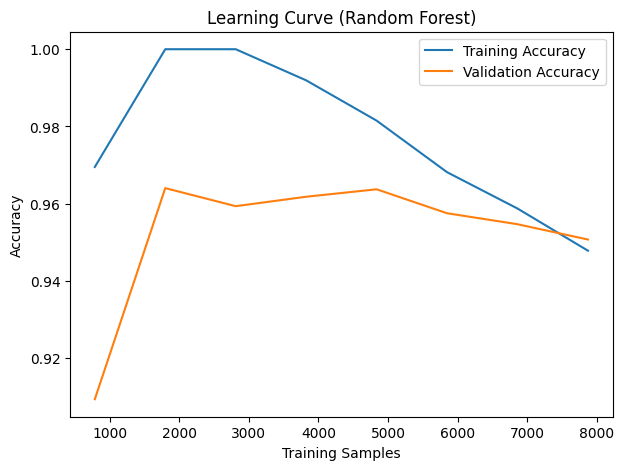

In [40]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    rf,                      # use Random Forest
    X_augmented,
    y_augmented,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.show()


In [41]:
# Save the model and symptoms list
import os
import pickle
import json

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model using pickle
with open('../models/disease_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the list of symptoms
with open('../models/symptoms.json', 'w') as f:
    json.dump(X.columns.tolist(), f)

print("Model and symptoms list saved successfully!")

Model and symptoms list saved successfully!


In [51]:
os.makedirs("models", exist_ok=True)

with open("../models/disease_model_rf.pkl", "wb") as file:
    pickle.dump(rf, file)

print("Model saved at:", "models/disease_model_rf.pkl")

Model saved at: models/disease_model_rf.pkl


In [50]:

ensemble_bundle = {
    "random_forest": rf,
    "logistic_regression": lr,
    "rf_weight": 0.7,
    "lr_weight": 0.3,
    "classes": classes,
    "symptoms": list(X.columns)
}

with open("../models/disease_model_ensemble.pkl", "wb") as f:
    pickle.dump(ensemble_bundle, f)
